In [ ]:
import pandas as pd, os, numpy as np, random as r, pickle, math
from matplotlib import pyplot as plt

# Things to do/consider (Oct 25)
   # Make CE actually EC2, combine into one class
   # Relabel merge safety cases, make the requirement 5% (peak-end) based
   # Label cases based on their scan rate ranges

def plot(df, save=False, name=None):
   for v in df['v'].unique():
      t = df.loc[df['v'] == v].copy()
      if 'newA' in t.columns:
         plt.scatter(t['V'], t['A'], s=0.1)
      else:
         plt.scatter(t['V'], t['A'], s=0.1)
   if save:
      plt.savefig(f'./Graphs/{name}', dpi=200)
   plt.show()
   plt.clf()

class Mech:
   def __init__(self, mech, cathodic):
      self.mech = mech
      self.cathodic = cathodic
      self.data = None
      self.file = None
      self.scaling = r.randint(50, 100)/100

   def __str__(self):
      return f'Mech: {self.mech}, Cathodic: {self.cathodic}, Scaling: {self.scaling}, File: {self.file}'

# Step zero, label each available file as either mergeable, half-mergeable, or not mergeable

# Step one – pick the four mechanisms (NO ERRORS)
def get_mechs():
   mechs = [None]*4
   x = r.randint(1, 8)
   if x == 1:
      cath = round(r.random())
      if cath:
         mechs[0] = Mech("T", True)
      else:
         mechs[-1] = Mech("T", False)

   x = r.randint(1, 8)
   if x == 2:
      cath = round(r.random())
      if cath and not mechs[0]:
         mechs[0] = Mech("ECP", True)
      elif cath:
         mechs[-1] = Mech("ECP", False)
      elif mechs[-1]:
         mechs[0] = Mech("ECP", True)
      else:
         mechs[-1] = Mech("ECP", False)

   # EC1 is equal to EC anodic or CE cathodic, EC2 is equal to CE anodic or EC cathodic
   remaining_mechs = ["E", "EC1", "ECE", "DISP", "CE"] # REMOVED SR
   for i, spot in enumerate(mechs):
      if not spot:
         x = r.randint(0, 4)
         cathodic = True if round(r.random()) == 1 else False
         mechs[i] = Mech(remaining_mechs[x], cathodic)
   
   return mechs

In [ ]:
# Step two – select files (NO ERRORS)
def get_files(mechs):
   for i, mech in enumerate(mechs):
      # safe means it can be merged from either side, so no special consideration is necessary
      safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_safe.pkl', 'rb'))
      # half safe means it is useable as a beginning or terminal mechanism so needs to be looked at
      half_safe = pickle.load(open(f'./Merge_Safety/{mech.mech}_half_safe.pkl', 'rb'))
      if i == 1 or i == 2:
         file = r.choice(list(safe.keys()))
      # considerations on if T or ECP need to be flipped have already been made so pick any file
      elif mech.mech == 'T' or mech.mech == 'ECP':
         options = list(safe.keys())
         options.extend(list(half_safe.keys()))
         file = r.choice(options)
      else:
         options = list(safe.keys())
         options.extend(list(half_safe.keys()))
         file = r.choice(options)
         if file not in safe:
            # if data is only mergeable from one side, we may need to over-ride the assigned flipping
            left_safe = half_safe[file][0]
            right_safe = half_safe[file][1]
            if left_safe: # must be flipped if it is left most, otherwise can't be
               if i == 0:
                  mech.cathodic = True
               else:
                  mech.cathodic = False
            else: # must be flipped if it right most, otherwise can't be
               if i == 0:
                  mech.cathodic = False
               else:
                  mech.cathodic = True
      mech.file = file
      mech.data = pd.read_csv(f'./Samples/{mech.mech}/{file}')
      min_V = min(mech.data['V'])
      mech.data['V'] = mech.data.loc[:,'V'].apply(lambda x : x-min_V)
      mech.data.reset_index(inplace=True, drop=True)

In [ ]:
# Step three – adjust data by scaling and reversing if cathodic
def adjust_data(mech):
   flip = -1 if mech.cathodic else 1
   mech.data['A'] = mech.data.loc[:,'A'].apply(lambda x : x*flip*mech.scaling)
   res = pd.DataFrame()
   if mech.cathodic:
      for v in mech.data['v'].unique():
         t = mech.data.loc[mech.data['v'] == v].copy()
         currents = t.loc[:,'A']
         n = len(currents)//2
         fwd_currents = list(currents[:n])
         rev_currents = list(currents[n:])
         rev_currents.extend(fwd_currents)
         t['A'] = rev_currents
         res = pd.concat([res, t])
      mech.data = res
   mech.data.reset_index(inplace=True, drop=True)

In [ ]:
# Step four – calculate merge points (not seeing any errors, maybe edge cases to look out for)
def calculate_merge_reps(mech, peak_frac=0.33, sr_rep=0):

   def find_index(l, r, target, data):
      decreasing = data.loc[l, 'A'] > data.loc[r, 'A']
      while (l <= r):
         m = l+(r-l) // 2
         if data.loc[m, 'A'] < target:
            if decreasing:
               r = m-1
            else:
               l = m+1
         else:
            if decreasing:
               l = m+1
            else:
               r = m-1
      return l if l <= data.index[-1] else data.index[-1]

   scan_rates = mech.data['v'].unique()
   rep_data = mech.data[mech.data['v'] == scan_rates[sr_rep]]

   max_A = max(rep_data['A'])
   min_A = min(rep_data['A'])
   
   peak_ratio = abs(min_A/max_A) if abs(min_A) < max_A else abs(max_A/min_A)
   reversible = peak_ratio >= 0.1
   main_peak = max_A if max_A > abs(min_A) else min_A
   # Mpi = max peak index, mpi = min peak index
   Mpi = rep_data[rep_data['A'] == max_A].index[0]
   mpi = rep_data[rep_data['A'] == min_A].index[0]

   merge_points = []
   indices = rep_data.index
   l = indices[0]
   r = indices[-1]
   n = indices[len(indices)//2]
   if rep_data.loc[Mpi, 'A'] == main_peak or reversible:
      target = peak_frac*(max_A-rep_data.loc[n,'A']) + rep_data.loc[n,'A']
      merge_points.append(find_index(l, Mpi, target, rep_data))
      merge_points.append(find_index(Mpi, n, target, rep_data))
   if rep_data.loc[mpi, 'A'] == main_peak or reversible:
      target = rep_data.loc[r,'A'] - peak_frac*(abs(min_A-rep_data.loc[r,'A']))
      merge_points.append(find_index(n+1,mpi, target, rep_data))
      merge_points.append(find_index(mpi, r, target, rep_data))
 
   mech.data['merge_point'] = False
   for point in merge_points:
      mech.data.loc[point, 'merge_point'] = True

In [ ]:
# Step five – execute merge

# Seems to be working
def __calculate_shifts(mechs, extra_shift_max=1000):

   def get_mps(indices, data):
      max_potential = data.loc[indices[0], 'V']
      min_potential = max_potential
      for i in range(1, len(indices)):
         cur = data.loc[indices[i], 'V']
         max_potential = max(max_potential, cur)
         min_potential = min(min_potential, cur)
      return [min_potential, max_potential]

   host = mechs[0].data
   mpis = host.loc[host['merge_point']].index
   host_mps = get_mps(mpis, host)
   shifts = [0]
   for i in range(1, len(mechs)):
      guest = mechs[i].data
      mpis = guest.loc[guest['merge_point']].index
      guest_mps = get_mps(mpis, guest)
      host_pot = host_mps[1]
      guest_pot = guest_mps[0]
      shift = (host_pot-guest_pot) + r.randint(0, extra_shift_max)
      shifts.append(shift)
      guest_mps[1] += shift
      host_mps = guest_mps
   return shifts

def __merge_dfs(dfs, rev=False):
   
   def addcurs(x, y):
         if math.isnan(x):
            x = 0
         if math.isnan(y):
            y = 0
         return x + y

   res = pd.DataFrame()
   left_adds = []
   right_adds = []
   for df in dfs:
      if rev:
         df = df[::-1]
      left_adds.append([min(df['V']), df.loc[df.index[0], 'A']])
      right_adds.append([max(df['V']), df.loc[df.index[-1], 'A']])   
      if len(res) == 0:
         res = df
      else:
         res = res.merge(df, how='outer', left_on=['V','v'], right_on=['V','v'])
         res['A'] = res.apply(lambda x: addcurs(x['A_x'], x['A_y']), axis=1)
         res.drop(['A_x', 'A_y'], axis=1, inplace=True)
      res.reset_index(inplace=True, drop=True)
   for left in left_adds:
      res['A'] = res.apply(lambda x: x['A'] + left[1] if x['V'] < left[0] else x['A'], axis=1)
   for right in right_adds:
      res['A'] = res.apply(lambda x: x['A'] + right[1] if x['V'] > right[0] else x['A'], axis=1)
   return res

def merge(mechs):
   # merging
   res = pd.DataFrame()
   for i in range(6):
      fwd_dfs = []
      rev_dfs = []
      name = ""
      global_max = 0
      for j, mech in enumerate(mechs):
         if j == 3:
            global_max = max(mech.data['V'])
         name += mech.file[:-4]
         data = mech.data[mech.data['v'] == i].copy()
         data.reset_index(inplace=True)
         n = data.loc[data['V'] == max(data['V'])].index[0]
         fwd_dfs.append(data.iloc[:n, :].copy())
         rev_dfs.append(data.iloc[n:, :].copy())
      fwd_full = __merge_dfs(fwd_dfs)
      rev_full = __merge_dfs(rev_dfs, rev=True)
      rev_full = rev_full[::-1]
      res = pd.concat([res, fwd_full, rev_full])
      res = res.loc[(res['V'] > 0) & (res['V'] < global_max)]
      return res # tabbed in for single scan rate


def initialize_data():
   mechs = get_mechs()
   get_files(mechs)
   for i, mech in enumerate(mechs):
      adjust_data(mech)
      calculate_merge_reps(mech)
   return mechs
   # shift data, remap scan rates, 
   # general *format*
def format_data():
   shifts = __calculate_shifts(mechs)
   for i, mech in enumerate(mechs):
      mech.data['V'] = mech.data['V'].apply(lambda x: x+shifts[i])
      mapping = {}
      for i,v in enumerate(mech.data['v'].unique()):
         mapping[v] = i
      mech.data.replace({'v': mapping}, inplace=True)
      mech.data.drop(['merge_point'], axis=1, inplace=True)
   
   # general *merge*
   finaldf = merge(mechs)
   for mech in mechs:
      t = mech.data[mech.data['v'] == max(mech.data['v'])].copy()
      print(mech)
      #plot(t)
   plot(finaldf)
   print()
   print()
   print()
   finaldf



In [ ]:

from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True)
gs = GridSpec(3,2, figure=fig, height_ratios=[1,1,1])

components = []
components.append(fig.add_subplot(gs[-2:-1, :1]))
components.append(fig.add_subplot(gs[-2:-1, -1:]))
components.append(fig.add_subplot(gs[-1:, :1]))
components.append(fig.add_subplot(gs[-1:, -1:]))

ax1 = fig.add_subplot(gs[:1,:])
ax1.scatter(finaldf['V'], finaldf['A'], s=0.01)
infos = [[],[],[]]
name = ""
for mech in mechs:
   name += mech.file[:-4] + "_"
   infos[0].append(mech.mech)
   infos[1].append(mech.scaling)
   infos[2].append("cathodic" if mech.cathodic else "anodic")
   ax = components.pop(0)
   data = mech.data[mech.data['v'] == max(mech.data['v'])].copy()
   ax.scatter(data['V'], data['A'], s=0.01)

ax1.table(infos, loc='top', cellLoc='center')
plt.savefig(name, dpi=200)

,V,A,v
0,-1099.0,-0.024673,0.1
1,-1098.0,-0.024651,0.1
2,-1097.0,-0.024629,0.1
3,-1096.0,-0.024607,0.1
4,-1095.0,-0.024584,0.1
...,...,...,...
25195,-1096.0,-0.136618,2.0
25196,-1097.0,-0.136500,2.0
25197,-1098.0,-0.136383,2.0
25198,-1099.0,-0.136265,2.0


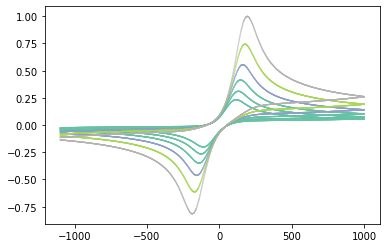

In [80]:
from matplotlib import pyplot as plt
import pandas as pd
f = pd.read_csv('./Samples/E/E_25.txt')
plt.scatter(f['V'], f['A'], s=0.05, c=f['v'], cmap='Set2')
f